# Deep Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import copy
import os
import pickle
from sklearn.utils import shuffle

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

To build our neural network, we'll be implementing several "helper functions." These helper functions will be used in a implementation aftwards.

- Initialize the parameters for an $L$-layer neural network
- Implement the forward propagation module (shown in purple in the figure below)
     - Complete the LINEAR part of a layer's forward propagation step (resulting in $Z^{[l]}$).
     - The ACTIVATION function
     - Combine the previous two steps into a new [LINEAR->ACTIVATION] forward function.
     - Stack the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer $L$). This gives we a new L_model_forward function.
- Compute the loss
- Implement the backward propagation module (denoted in red in the figure below)
    - Complete the LINEAR part of a layer's backward propagation step
    - The gradient of the ACTIVATION function
    - Combine the previous two steps into a new [LINEAR->ACTIVATION] backward function
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally, update the parameters

<center><img src="images/final outline.png" style="width:800px;height:500px;"></center>
<caption><center><b>Figure 1</b></center></caption><br>

For every forward function, there is a corresponding backward function. This is why at every step from the forward module we will be storing some values in a cache. These cached values are useful for computing gradients. In the backpropagation module, the cache is used to calculate the gradients.

## Initialization

We will use [np.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html) and [np.zeros](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html).

### L-layer Neural Network

The initialization for a deeper L-layer neural network is complicated because there are many weight matrices and bias vectors. The dimensions should match between each layer. The number of units in layer $l$ is $n^{[l]}$ is . For example, if the size of your input $X$ is $(3072, 3000)$ (with $m=3000$ examples) then:

<table style="width:100%">
    <tr>
        <td>  </td> 
        <td> <b>Shape of W</b> </td> 
        <td> <b>Shape of b</b>  </td> 
        <td> <b>Activation</b> </td>
        <td> <b>Shape of Activation</b> </td> 
    <tr>
    <tr>
        <td> <b>Layer 1</b> </td> 
        <td> $(n^{[1]},3072)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        <td> $(n^{[1]},3000)$ </td> 
    <tr>
    <tr>
        <td> <b>Layer 2</b> </td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 3000)$ </td> 
    <tr>
       <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
    <tr>  
   <tr>
       <td> <b>Layer L-1</b> </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 3000)$ </td> 
   <tr>
   <tr>
       <td> <b>Layer L</b> </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 3000)$  </td> 
    <tr>
</table>

When $W X + b$ is computed in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    w_{00}  & w_{01} & w_{02} \\
    w_{10}  & w_{11} & w_{12} \\
    w_{20}  & w_{21} & w_{22} 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    x_{00}  & x_{01} & x_{02} \\
    x_{10}  & x_{11} & x_{12} \\
    x_{20}  & x_{21} & x_{22} 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    b_0  \\
    b_1  \\
    b_2
\end{bmatrix}\tag{1}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (w_{00}x_{00} + w_{01}x_{10} + w_{02}x_{20}) + b_0 & (w_{00}x_{01} + w_{01}x_{11} + w_{02}x_{21}) + b_0 & \cdots \\
    (w_{10}x_{00} + w_{11}x_{10} + w_{12}x_{20}) + b_1 & (w_{10}x_{01} + w_{11}x_{11} + w_{12}x_{21}) + b_1 & \cdots \\
    (w_{20}x_{00} + w_{21}x_{10} + w_{22}x_{20}) + b_2 &  (w_{20}x_{01} + w_{21}x_{11} + w_{22}x_{21}) + b_2 & \cdots
\end{bmatrix}\tag{2}  $$


In [2]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims) # number of layers in the network
    
    for l in range(1, L):
        # Dividing by sqrt of layer so ...
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    
    return parameters

## Forward Propagation Module

### Linear Forward 

We'll be implementing three functions in this order:

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{3}$$

where $A^{[0]} = X$. 

In [3]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b"; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    
    cache = (A, W, b)
    
    return Z, cache

### Linear-Activation Forward

We will use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. The `sigmoid` function is going to  returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it we could just call: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. This function will return **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what we'll feed in to the corresponding backward function). To use it we could just call:
``` python
A, activation_cache = relu(Z)
```

For added convenience, we're going to group two functions (Linear and Activation) into one function (LINEAR->ACTIVATION). Hence, we'll implement a function that does the LINEAR forward step, followed by an ACTIVATION forward step.


In [4]:
def sigmoid(Z):
    """
    Implement the sigmoid activation function.

    Arguments:
    Z -- numpy array of any shape

    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    
    return A, cache


def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0, Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache



def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    else:
        print("\033[91mError! Please make sure you have passed the value correctly in the \"activation\" parameter")
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache

### L-Layer Model 

For even *more* convenience when implementing the $L$-layer Neural Net, we will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

<center><img src="images/model_architecture_kiank.png" style="width:600px;height:300px;"></center>
<caption><center> <b>Figure 2</b> : *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model</center></caption><br>

###  L_model_forward

In the code below, the variable `AL` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.) 

In [5]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    # The for loop starts at 1 because layer 0 is the input
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,
                                             parameters['W' + str(l)],
                                             parameters['b' + str(l)],
                                             'relu')
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A,
                                          parameters['W' + str(L)],
                                          parameters['b' + str(L)],
                                          'sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))

    return AL, caches

## Cost Function

In order to check whether the model is actually learning, we need to compute the cost using the following formula:

$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{4}$$


In [6]:
def compute_cost(AL, Y):
    """
    Implement the cost function.

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

## Backward Propagation Module

Just as done on forward propagation, we will be implementing helper functions for backpropagation. This step is used to calculate the gradient of the loss function with respect to the parameters. 

**Reminder**: 
<center><img src="images/backprop_kiank.png" style="width:650px;height:250px;"></center>
<caption><center><font color='purple'><b>Figure 3</b>: Forward and Backward propagation for LINEAR->RELU->LINEAR->SIGMOID <br> <i>The purple blocks represent the forward propagation, and the red blocks represent the backward propagation.</font></center></caption>


The chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{5} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, use the previous chain rule and we do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During backpropagation, at each step we multiply our current gradient by the gradient corresponding to the specific layer to get the gradient we wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, we use the previous chain rule and $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

Now, similarly to forward propagation, we're going to build the backward propagation in three steps:
1. LINEAR backward
2. LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
3. [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

### Linear Backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose we have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. We want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

<center><img src="images/linearback_kiank.png" style="width:250px;height:300px;"></center>
<caption><center><font color='purple'><b>Figure 4</b></font></center></caption>

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.

Here are the formulas used:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{6}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{7}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{8}$$


$A^{[l-1] T}$ is the transpose of $A^{[l-1]}$. 

In [7]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dA_prev = np.dot(W.T, dZ)
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [8]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    activation_cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

### Linear-Activation Backward

We will also need functions with the derivatives with relatiosions to thje activation functions.

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}). \tag{9}$$  


- **`sigmoid_backward`**:

$$
dZ^{[l]} = \begin{cases}
dA^{[l]}, & \text{if } Z^{[l]} > 0 \\
0, & \text{if } Z^{[l]} \leq 0
\end{cases}
\tag{10}
$$

- **`relu_backward`**:

$$
dZ^{[l]} = dA^{[l]} \cdot \sigma(Z^{[l]}) \cdot (1 - \sigma(Z^{[l]}))
\tag{11}
$$

In [9]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

### L-Model Backward 

Finally implementing the backward function for the whole network.

At each iteration, the `L_model_forward` function stores a cache which contains (X, W, b, and z) that is going to be used in the back propagation module to compute the gradients. The `L_model_backward` function iterate through all the hidden layers backward, starting from layer $L$. On each step, the cached values are used for layer $l$ to backpropagate through layer $l$. Figure 5 below shows the backward pass. 


<center><img src="images/mn_backward.png" style="width:450px;height:300px;"></center>
<caption><center><font color='purple'><b>Figure 5</b>: Backward pass</font></center></caption>

**Initializing backpropagation**:

Knowing that $A^{[L]} = \sigma(Z^{[L]})$, to backpropagate through this network, we need to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.

To do so, we use this formula (derived using calculus):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

Implementation of backpropagation for the *[LINEAR->RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model.

In [10]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
    
    return grads


### Update Parameters

To update the parameters of the model we use gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{12}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{13}$$

where $\alpha$ is the learning rate. 

After computing the updated parameters, store them in the parameters dictionary. 

In [11]:
def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
    
    return parameters

# Deep Neural Network for image classification

## Load and Process the Dataset

We'll be using a [CIFAR-10](https://paperswithcode.com/dataset/cifar-10) dataset.

The CIFAR-10 dataset (Canadian Institute for Advanced Research, 10 classes) is a subset of the Tiny Images dataset and consists of 60000 32x32 color images. The images are labelled with one of 10 mutually exclusive classes: airplane, automobile (but not truck or pickup truck), bird, cat, deer, dog, frog, horse, ship, and truck (but not pickup truck). There are 6000 images per class with 5000 training and 1000 testing images per class.

In our case, we will do a binary classification between cat (class 1) images and the other classes (class 0).

In [12]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Path to the CIFAR-10 dataset
cifar10_path = 'datasets//cifar-10-batches-py/'

# Load all training batches
train_data = []
train_labels = []
for i in range(1, 6):
    batch = unpickle(os.path.join(cifar10_path, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels.append(batch[b'labels'])

train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)

# Load test batch
test_batch = unpickle(os.path.join(cifar10_path, 'test_batch'))
test_data = test_batch[b'data']
test_labels = np.array(test_batch[b'labels'])

# Load label names
meta = unpickle(os.path.join(cifar10_path, 'batches.meta'))
label_names = meta[b'label_names']

# Convert byte strings to normal strings
label_names = [label.decode('utf-8') for label in label_names]


In [13]:
# Define the label for the "cat" class
cat_label = label_names.index('cat')

# Separate cat images from other images in the training set
train_cat_indices = np.where(train_labels == cat_label)[0]
train_other_indices = np.where(train_labels != cat_label)[0]

train_cat_data = train_data[train_cat_indices]
train_other_data = train_data[train_other_indices]

train_cat_labels = np.ones(train_cat_indices.shape[0])  # Label 1 for cats
train_other_labels = np.zeros(train_other_indices.shape[0])  # Label 0 for other classes

# Repeat for the test set
test_cat_indices = np.where(test_labels == cat_label)[0]
test_other_indices = np.where(test_labels != cat_label)[0]

test_cat_data = test_data[test_cat_indices]
test_other_data = test_data[test_other_indices]

test_cat_labels = np.ones(test_cat_indices.shape[0])  # Label 1 for cats
test_other_labels = np.zeros(test_other_indices.shape[0])  # Label 0 for other classes

classes = [
    'Other',
    'Cat'
    ]

We should choose how many training examples we will use to feed the model. This can be adjusted so to improve accuracy or reduce amount of time to train.

In [14]:
num_train_exem = 3000
train_class_examples = int(num_train_exem / 2)
test_class_examples = int(num_train_exem / 10)

In [15]:
train_cat_data, train_cat_labels = shuffle(train_cat_data, train_cat_labels, random_state=0)
train_other_data, train_other_labels = shuffle(train_other_data, train_other_labels, random_state=0)
test_cat_data, test_cat_labels = shuffle(test_cat_data, test_cat_labels, random_state=0)
test_other_data, test_other_labels = shuffle(test_other_data, test_other_labels, random_state=0)

train_data = np.vstack((train_cat_data[:train_class_examples], train_other_data[:train_class_examples]))
train_labels = np.concatenate((train_cat_labels[:train_class_examples], train_other_labels[:train_class_examples]))

test_data = np.vstack((test_cat_data[:test_class_examples], test_other_data[:test_class_examples]))
test_labels = np.concatenate((test_cat_labels[:test_class_examples], test_other_labels[:test_class_examples]))

train_data, train_labels = shuffle(train_data, train_labels, random_state=0)
test_data, test_labels = shuffle(test_data, test_labels, random_state=0)


Cat Images:


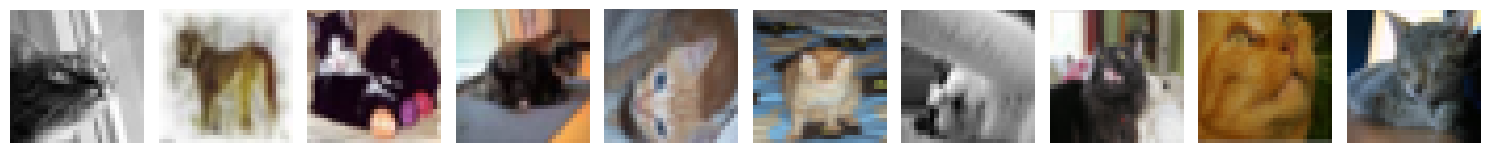

Other Images:


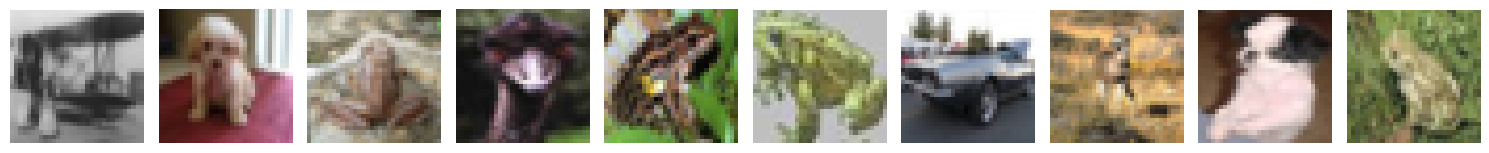

In [16]:
def plot_image(data, indices):
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(indices):
        img = data[idx].reshape(3, 32, 32).transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_cat_and_other_images(cat_data, other_data, label_names):
    num_cat_images = 10
    num_other_images = 10

    # Plot 10 cat images
    print("Cat Images:")
    plot_image(cat_data, range(num_cat_images))

    # Plot 10 other images
    print("Other Images:")
    plot_image(other_data, range(num_other_images))

plot_cat_and_other_images(train_cat_data[:10], train_other_data[:10], classes)


In [17]:
m_train = train_data.shape[0]
num_px = train_data.shape[1]
m_test = test_data.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_data shape: " + str(train_data.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_data shape: " + str(test_data.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training examples: 3000
Number of testing examples: 600
Each image is of size: (3072, 3072, 3)
train_data shape: (3000, 3072)
train_labels shape: (3000,)
test_data shape: (600, 3072)
test_labels shape: (600,)


We will reshape and standardize the images before feeding them to the network.

In [18]:
# Reshape the training and test examples 
train_x_flatten = train_data.T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_data.T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (3072, 3000)
test_x's shape: (3072, 600)


**Note**:
$3.072$ equals $32 \times 32 \times 3$, which is the size of one reshaped image vector.

## Model Architecture

You're going to build two different models:

- A 2-layer neural network
- An L-layer deep neural network

We'll compare the performance of these models, and try out some different values for $L$. 

### 2-layer Neural Network

The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.

<u><b>Detailed Architecture</b></u>:
- The input is a (32,32,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{3072}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias). 
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.


### L-layer Deep Neural Network

It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:

The model can be summarized as: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID

<u><b>Detailed Architecture</b></u>:
- The input is a (32,32,3) image which is flattened to a vector of size (3072,1).
- The corresponding vector: $[x_0,x_1,...,x_{3072}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, take the sigmoid of the final linear unit. If it is greater than 0.5, classify it as a cat.



### General Methodology

The Deep Learning methodology to build is as follows:

1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    a. Forward propagation
    b. Compute cost function
    c. Backward propagation
    d. Update parameters (using parameters, and grads from backprop) 
3. Use trained parameters to predict labels

## Two-layer Neural Network

In [19]:
### CONSTANTS DEFINING THE MODEL ####
n_x = train_x.shape[0]     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
lr = 0.005

In [20]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters([n_x, n_h, n_y])
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Reshape Y if necessary
    if Y.ndim == 1:
        Y = Y.reshape(1, -1)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        
        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.rcParams['figure.figsize'] = (5.0, 4.0)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

Cost after iteration 0: 0.708916314206992
Cost after iteration 100: 0.6714707928032503
Cost after iteration 200: 0.6556958515961895
Cost after iteration 300: 0.6468477826876718
Cost after iteration 400: 0.6407603618846077
Cost after iteration 500: 0.6359587463425349
Cost after iteration 600: 0.6317992767299335
Cost after iteration 700: 0.6281157061922374
Cost after iteration 800: 0.6247761067249639
Cost after iteration 900: 0.6216983023727647
Cost after iteration 1000: 0.6187982725641169
Cost after iteration 1100: 0.6161391956732423
Cost after iteration 1200: 0.6136439654027661
Cost after iteration 1300: 0.6112949326048784
Cost after iteration 1400: 0.6090543763208502
Cost after iteration 1500: 0.6069123912367839
Cost after iteration 1600: 0.6048491762398406
Cost after iteration 1700: 0.6028965205322311
Cost after iteration 1800: 0.6010271644921251
Cost after iteration 1900: 0.5992277762192402
Cost after iteration 2000: 0.5975105183960847
Cost after iteration 2100: 0.595867788198511
Co

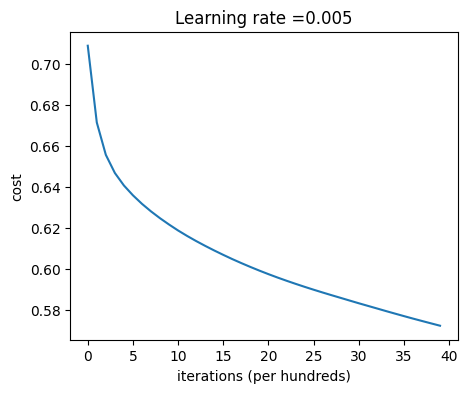

In [21]:
parameters, costs = two_layer_model(train_x,
                                    train_labels,
                                    layers_dims = (n_x, n_h, n_y),
                                    learning_rate = lr,
                                    num_iterations = 4000,
                                    print_cost=True)
plot_costs(costs, learning_rate = lr)

In [22]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

def print_mislabeled_images(classes, X, y, p, num_images=10):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    mislabeled_indices = np.where(p != y)[1]
    
    plt.rcParams['figure.figsize'] = (20.0, 20.0)  # set default size of plots
    num_images = min(len(mislabeled_indices), num_images)
    
    if num_images > 10:
        num_images = 10
    
    for i in range(num_images):
        index = mislabeled_indices[i]
        
        plt.subplot(1, num_images, i + 1)
        img = X[index].reshape(3, 32, 32).transpose(1, 2, 0)
        plt.imshow(img, interpolation='nearest')
        plt.axis('off')
        plt.title(f"Prediction: {classes[int(p[0][index])]} \n Class: {classes[int(y[index])]}")
    
    plt.tight_layout()
    plt.show()


def print_correctly_labeled_images(classes, X, y, p, num_images=10):
    """
    Plots images where predictions and truth were the same.
    
    Parameters:
    classes -- list of class names
    X -- dataset (images)
    y -- true labels
    p -- predictions
    num_images -- number of images to plot (default is 10)
    """
    correctly_labeled_indices = np.where(p == y)[1] 
    
    plt.rcParams['figure.figsize'] = (20.0, 20.0)  # set default size of plots
    num_images = min(len(correctly_labeled_indices), num_images)
    
    for i in range(num_images):
        index = correctly_labeled_indices[i]
        
        plt.subplot(1, num_images, i + 1)
        img = X[index].reshape(3, 32, 32).transpose(1, 2, 0)
        plt.imshow(img, interpolation='nearest')
        plt.axis('off')
        plt.title(f"Prediction: {classes[int(p[0][index])]} \n Class: {classes[int(y[index])]}")
    
    plt.tight_layout()
    plt.show()

In [23]:
pred_train = predict(train_x, train_labels, parameters)

Accuracy: 0.7083333333333335


In [24]:
pred_test = predict(test_x, test_labels, parameters)

Accuracy: 0.6699999999999999


Misclassified images: 


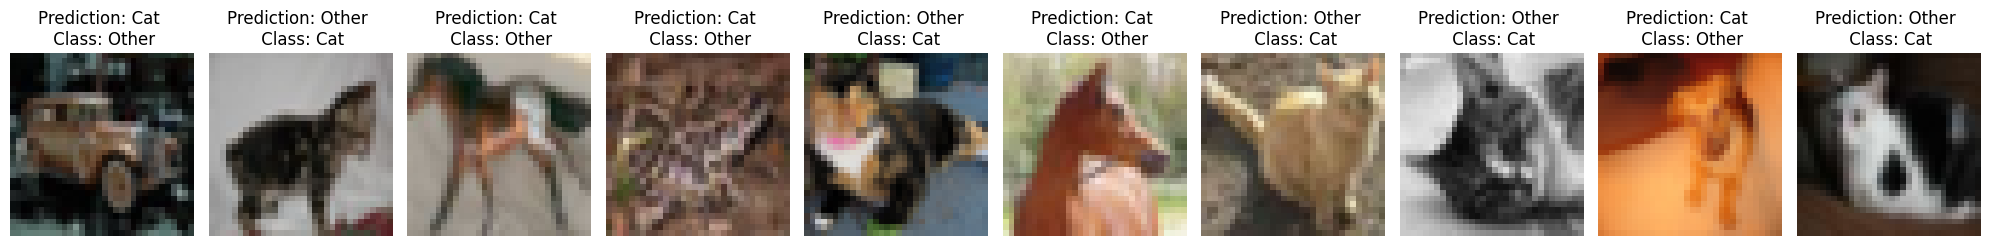

Corectly classified images: 


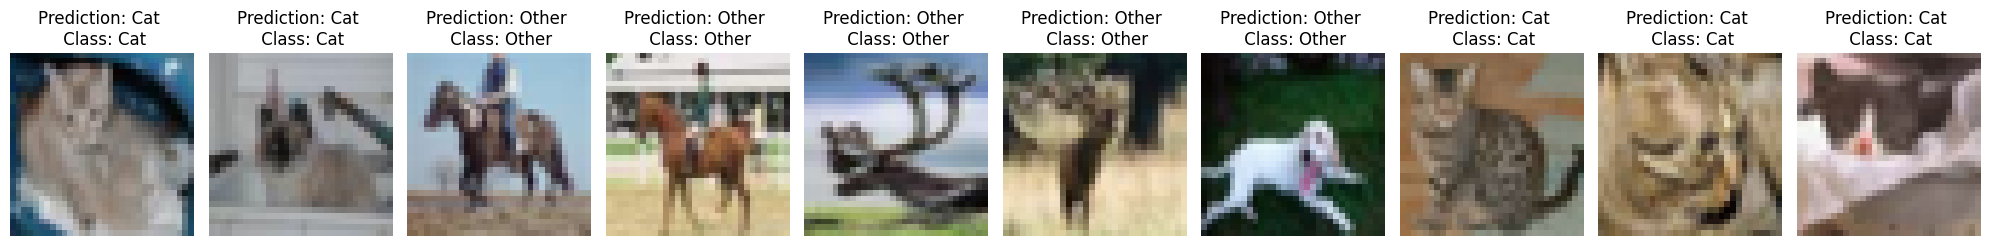

In [25]:
print("Misclassified images: ")
print_mislabeled_images(classes, test_data, test_labels, pred_test)

print("Corectly classified images: ")
print_correctly_labeled_images(classes, test_data, test_labels, pred_test)

## L-layer Neural Network

In [26]:
### CONSTANTS ###
layers_dims = [train_x.shape[0], 20, 10, 6, 1]  # 4 layer model

In [27]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters(layers_dims)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Reshape Y if necessary
    if Y.ndim == 1:
        Y = Y.reshape(1, -1)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

Cost after iteration 0: 0.6961971460409616
Cost after iteration 100: 0.6730181658427001
Cost after iteration 200: 0.6575912415486924
Cost after iteration 300: 0.6470775719295685
Cost after iteration 400: 0.6390471644302111
Cost after iteration 500: 0.6324205963529013
Cost after iteration 600: 0.6266859504581112
Cost after iteration 700: 0.6212463783632127
Cost after iteration 800: 0.6151907009807902
Cost after iteration 900: 0.6089872575098455
Cost after iteration 1000: 0.6031395230944253
Cost after iteration 1100: 0.5973900050035836
Cost after iteration 1200: 0.591784985987397
Cost after iteration 1300: 0.5862288175707392
Cost after iteration 1400: 0.5797332119491564
Cost after iteration 1500: 0.5740130530160821
Cost after iteration 1600: 0.5686322115799601
Cost after iteration 1700: 0.5635176017397892
Cost after iteration 1800: 0.5585006485755608
Cost after iteration 1900: 0.5536233446946461
Cost after iteration 2000: 0.5510818863101458
Cost after iteration 2100: 0.551913314710816
Co

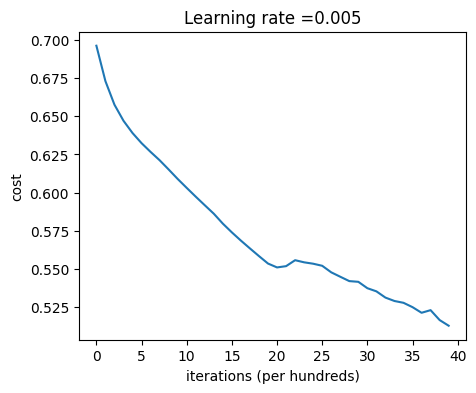

In [28]:
parameters, costs = L_layer_model(train_x,
                                  train_labels,
                                  layers_dims,
                                  learning_rate = lr,
                                  num_iterations = 4000,
                                  print_cost = True)

plot_costs(costs, learning_rate = lr)

In [29]:
pred_train = predict(train_x, train_labels, parameters)

Accuracy: 0.7456666666666667


In [30]:
pred_test = predict(test_x, test_labels, parameters)

Accuracy: 0.685


Misclassified images: 


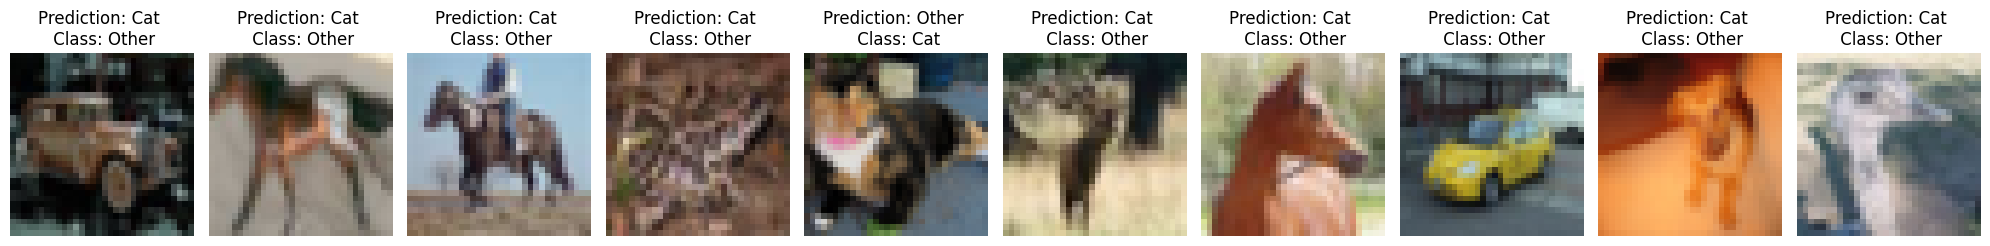

Corectly classified images: 


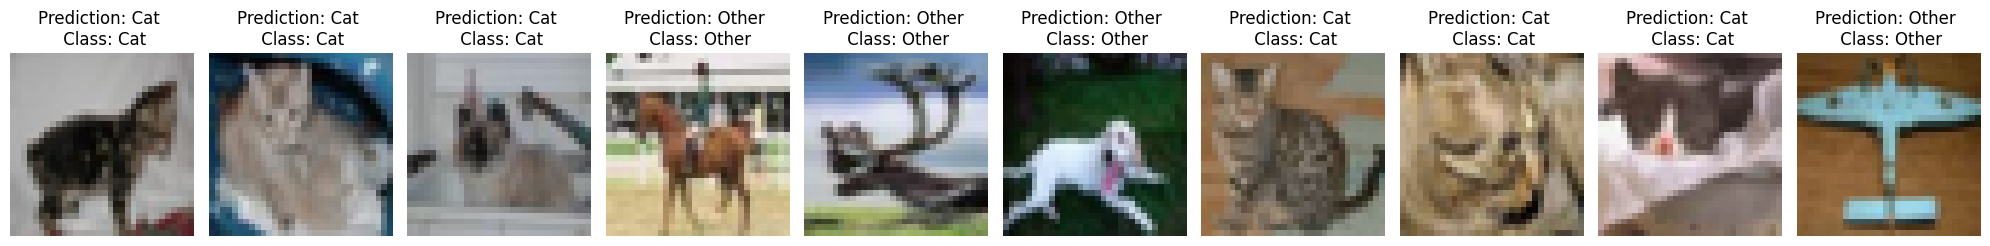

In [31]:
print("Misclassified images: ")
print_mislabeled_images(classes, test_data, test_labels, pred_test)

print("Corectly classified images: ")
print_correctly_labeled_images(classes, test_data, test_labels, pred_test)

The model is far from perfect, but just for demonstration purposes, it is fine enough.